ref: https://www.kaggle.com/meddulla/predicting-survival

Categorical encoding: https://pbpython.com/categorical-encoding.html

Feature selection: 
* https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
* https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
* https://towardsdatascience.com/feature-selection-techniques-for-classification-and-python-tips-for-their-application-10c0ddd7918b

# Trabalho Final Data Mining

*Turma Bi Master 2019.3*

**Professora**: Manoela Kohler

**Aluno**: Rodrigo Moreira Araújo

**Matrícula**: 192.190.075

## Índice:

1. [Descrição do problema](#descricao)
2. [Análise Exploratória](#analise-exp)
    1. [Importação](#2-importacao)
    2. [Criação dos DataFrames](#2-criacao)
3. [Valores faltantes](#faltantes)
    1. [Categóricos](#3-categoricos)
    2. [Numéricos](#3-numericos)
4. [Atributos desnecessários](#desnecessarios)
    1. [Univariate filter methods](#4-univariate)
    2. [Análise através de correlação](#4-correlacao)
5. [Balanceamento](#balanceamento)

## 1. Descrição do problema <a class="anchor" id="descricao"></a>

**Problema de classificação**

* 27 atributos numéricos e categóricos que descrevem o estado de saúde de cavalos; 
* Três classes de saída que indicam o que aconteceu com o cavalo: morreu, viveu ou se foi submetido à eutanásia. A ideia é prever se um cavalo pode sobreviver ou não baseado nas condições médicas passadas.

## 2. Análise exploratória dos dados <a class="anchor" id="analise-exp"></a>

#### A. Importação dos módulos necessários <a class="anchor" id="2-importacao"></a>

In [602]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para visualização com Seaborn
import seaborn as sns

# Para a seleção de atributos relevantes
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# Para balanceamento do conjunto através do SMOTE
!pip3 install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

#### B. Criação dos DataFrames de treino (df) e  teste (df_test) <a class="anchor" id="2-criacao"></a>

In [603]:
# Criação dos DataFrames de treino e teste

df = pd.read_csv("horse.csv")
df_test = pd.read_csv("horseTest.csv")

df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


## 3. Verificação de valores faltantes (*missing values*) <a class="anchor" id="faltantes"></a>

In [604]:
# Extrai o número total de linhas do Dataframe
total_lines = df.shape[0]

# Avalia o número de linhas preenchidas por coluna
cols_count = df.count(axis=0)

# Seleciona apenas as colunas com dados faltantes
missing_cols = cols_count[cols_count != total_lines]

# Verifica o tipo das colunas com dados faltantes
col_types = df[missing_cols.index].dtypes

# Segrega as colunas de float e de string
float_cols = col_types[col_types == "float64"]
str_cols = col_types[col_types == "object"]

# Lista de colunas com total de valores
missing_cols

rectal_temp              239
pulse                    275
respiratory_rate         241
temp_of_extremities      243
peripheral_pulse         230
mucous_membrane          252
capillary_refill_time    267
pain                     244
peristalsis              255
abdominal_distention     243
nasogastric_tube         195
nasogastric_reflux       193
nasogastric_reflux_ph     53
rectal_exam_feces        197
abdomen                  181
packed_cell_volume       270
total_protein            266
abdomo_appearance        134
abdomo_protein           101
dtype: int64

#### Preenchimento dos valores faltantes das colunas categóricas <a class="anchor" id="3-categoricos"></a>

In [605]:
# Extrai a moda de cada uma das colunas de string com valores faltantes
col_modes = df[str_cols.index].mode()
df[col_modes.columns] = df[col_modes.columns].fillna(col_modes.iloc[0], axis=0)
df[col_modes.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
temp_of_extremities      299 non-null object
peripheral_pulse         299 non-null object
mucous_membrane          299 non-null object
capillary_refill_time    299 non-null object
pain                     299 non-null object
peristalsis              299 non-null object
abdominal_distention     299 non-null object
nasogastric_tube         299 non-null object
nasogastric_reflux       299 non-null object
rectal_exam_feces        299 non-null object
abdomen                  299 non-null object
abdomo_appearance        299 non-null object
dtypes: object(12)
memory usage: 28.2+ KB


#### Preenchimento dos valores faltantes das colunas numéricas  <a class="anchor" id="3-numericos"></a>

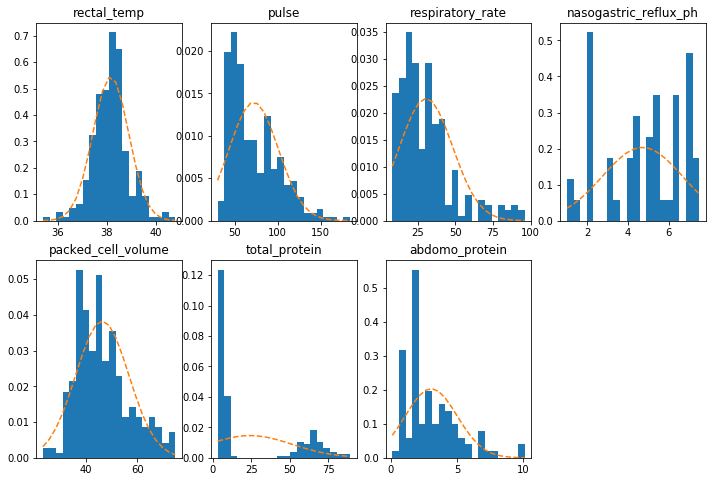

In [606]:
# Análise das distribuições dos valores faltantes do tipo float
def plot_histograms(dataframe, cols):
    fig = plt.figure(figsize=(12,8))
    for i, col in enumerate(cols.index):
        plt.subplot(2, 4, i+1)
        plt.title(col)
        vals = np.array(dataframe[col].copy().dropna().values)
        # Plota o histograma
        nhist, bins, patches = plt.hist(vals, bins=20, density=True)
        # Cálculo dos parâmetros da distribuição normal
        mean = vals.mean() 
        std = vals.std()  
        y = ((1/(np.sqrt(2*np.pi)*std))*np.exp(-0.5*(1/std*(bins-mean))**2))
        # Plota a gaussiana que melhor ajusta o histograma
        plt.plot(bins, y, '--')

plot_histograms(df, float_cols)

A análise dos histogramas permite concluir que as colunas `rectal_temp`, `packed_cell_volume`, `pulse` e `respiratory_rate` se aproximam razoavelmente de distribuições normais. Assim, os valores faltantes podem ser preenchidos com a mediana.

Para as outras três colunas (`nasograstric_reflux_ph`, `total_protein`, `abdomo_protein`), será usada a moda.

In [607]:
normal_float_cols = ["rectal_temp","packed_cell_volume","pulse","respiratory_rate"]
other_float_cols = ["nasogastric_reflux_ph", "total_protein", "abdomo_protein"]
for col in normal_float_cols:
    df[col] = df[col].fillna(df[col].median())
for col in other_float_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df[float_cols.index].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 7 columns):
rectal_temp              299 non-null float64
pulse                    299 non-null float64
respiratory_rate         299 non-null float64
nasogastric_reflux_ph    299 non-null float64
packed_cell_volume       299 non-null float64
total_protein            299 non-null float64
abdomo_protein           299 non-null float64
dtypes: float64(7)
memory usage: 16.5 KB


In [608]:
# Confirmando que todo o dataframe encontra-se preenchido
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
surgery                  299 non-null object
age                      299 non-null object
hospital_number          299 non-null int64
rectal_temp              299 non-null float64
pulse                    299 non-null float64
respiratory_rate         299 non-null float64
temp_of_extremities      299 non-null object
peripheral_pulse         299 non-null object
mucous_membrane          299 non-null object
capillary_refill_time    299 non-null object
pain                     299 non-null object
peristalsis              299 non-null object
abdominal_distention     299 non-null object
nasogastric_tube         299 non-null object
nasogastric_reflux       299 non-null object
nasogastric_reflux_ph    299 non-null float64
rectal_exam_feces        299 non-null object
abdomen                  299 non-null object
packed_cell_volume       299 non-null float64
total_protein            299 non-nul

#### C. Tratamento de colunas categóricas <a class="anchor" id="3-categoricos"></a>

In [609]:
# Extração das colunas que possuem dados categóricos
categorical_cols = df.select_dtypes(include=['object']).columns

# O for abaixo serve apenas para debug
# for col in categorical_cols:
#     print(col)
#     print(df[col].value_counts(), "\n")

As colunas `surgery`, `surgical_lesion`, `cp_data`, `age`, `capillary_refill_time`, `temp_of_extremities`, `peripheral_pulse`, `capillary_refill_time`, `pain`, `peristalsis`, `abdominal_distention`, `nasogastric_tube`, `nasogastric_reflux`, `rectal_exam_feces`, `mucous_membrane`, `abdomen`, `abdomo_appearance` possuem valores categóricos.

Porém, a sua conversão pode ser feita para valores numéricos de forma diferente:
* **Colunas `surgery`, `surgical_lesion`, `cp_data`**: contém apenas `yes` e `no`, então podem ser diretamente convertidas para 0 e 1;
* **Colunas `age`, `capillary_refill_time`, `temp_of_extremities`, `peripheral_pulse`, `capillary_refill_time`, `pain`, `peristalsis`, `abdominal_distention`, `nasogastric_tube`, `nasogastric_reflux`, `rectal_exam_feces`**: contém valores sequenciais, então podem ser convertidas para inteiros em sequência;
* **Colunas `mucous_membrane`, `abdomen`, `abdomo_appearance`**: contém categorias e serão convertidas com *One Hot Encoding*

In [610]:
for curr_df in [df, df_test]:
    yes_no_cols = ["surgery", "surgical_lesion", "cp_data"]
    curr_df[yes_no_cols] = curr_df[yes_no_cols].replace({"yes":1,"no":0})
    curr_df["age"] = curr_df["age"].replace({"young":0, "adult":1})
    curr_df["capillary_refill_time"] = curr_df["capillary_refill_time"].replace({1:0, 2:1})

    curr_df["temp_of_extremities"] = curr_df["temp_of_extremities"].replace({"cold":0, "normal":1, "cool":2, "warm":3})
    curr_df["peripheral_pulse"] = curr_df["peripheral_pulse"].replace({"absent":0, "reduced":1, "normal":2, "increased":3})
    curr_df["capillary_refill_time"] = curr_df["capillary_refill_time"].replace({"less_3_sec":0, "3":1, "more_3_sec":2})
    curr_df["pain"] = curr_df["pain"].replace({"alert":0, "depressed":1, "mild_pain":2, "severe_pain":3, "extreme_pain":4})
    curr_df["peristalsis"] = curr_df["peristalsis"].replace({"hypermotile":0, "normal":1, "hypomotile":2, "absent":3})
    curr_df["abdominal_distention"] = curr_df["abdominal_distention"].replace({"none":0, "moderate":1, "slight":2, "severe":3})
    curr_df["nasogastric_tube"] = curr_df["nasogastric_tube"].replace({"none":0, "slight":1, "significant":2})
    curr_df["nasogastric_reflux"] = curr_df["nasogastric_reflux"].replace({"none":0, "less_1_liter":1, "more_1_liter":2})
    curr_df["rectal_exam_feces"] = curr_df["rectal_exam_feces"].replace({"absent":0, "decreased":1, "normal":2, "increased":2})

    # Como o objetivo é avaliar se o cavalo sobreviveu, os valores died e euthanized serão tratados indistintamente
    curr_df["outcome"] = curr_df["outcome"].replace({"died":0, "euthanized":0, "lived":1})

In [611]:
# Criando One Hot Encoding das variáveis categóricas restantes: mucous_membrane, abdomen, abdomo_appearance
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

In [612]:
# Garantindo a consistência das colunas criadas com One Hot Encoding entre os DataFrames de treino e teste

train_cols = df.columns
test_cols = df_test.columns

train_cols == test_cols

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

#### D. Normalização dos dados

In [613]:
df=(df-df.min())/(df.max()-df.min())

## 4. Atributos desnecessários  <a class="anchor" id="desnecessarios"></a>

A seleção de atributos com maior impacto na saída será feita com base na função [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) do Scikit Learn e na avaliação da correlação entre cada um dos atributos e a variável de saída `outcome`

Para o primeiro caso, serão construídas 4 listas de 10 atributos: 1 para cada uma das funções de rankeamento (chi2, f_classif e mutual_info_classif) disponíveis no Scikit Learn e uma considerando um rankeamento conjunto com base nas três funções.

#### A. Univariate filter methods <a class="anchor" id="4-univariate"></a>

In [687]:
np.random.seed(100)
# Extrai a lista de todas as colunas do DataFrame
all_cols = list(df.columns.values)

# Remove a coluna de resultado e constrói um novo DataFrame X apenas com as colunas de entrada
all_cols.remove("outcome")
x_cols = all_cols
X = df[x_cols]

# Constrói uma nova Series y com a coluna de saída
y = df["outcome"]

# Utiliza a função SelectKBest do ScikitLearn e constrói um dicionário com o ranking
# de atributos para cada score function: chi2, f_classif e mutual_info_classif
feature_scores = []
best_feats = {}
all_funcs = {"chi2":chi2, "f_classif":f_classif, "mutual_info_classif": mutual_info_classif}
for score_func in all_funcs:
    best_features = SelectKBest(score_func=all_funcs[score_func], k=15)
    fit = best_features.fit(X,y)
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(X.columns)
    df_features = pd.concat([df_columns,df_scores], axis=1)
    df_features.columns = ["Specs", f"Score {score_func}"]
    feature_scores.append(df_features)
    df_features = df_features.sort_values(f"Score {score_func}", ascending=False)
    df_features = df_features.reset_index()
    best_feats[score_func] = df_features

# Constrói um novo ranking levando em consideração as posições dos atributos nos 3
# ranking gerados anteriormente
n_attrs = df.shape[1]-1
vals = []
for attr in all_cols:
    vals.append(0)
    for func in best_feats:
        curr_df = best_feats[func]
        vals[-1] += n_attrs - curr_df[curr_df["Specs"] == attr].index[0]
attr_df = pd.DataFrame({"Columns":all_cols, "New ranking":vals}).sort_values("New ranking", ascending=False)
# attr_df

In [689]:
# Constrói um DataFrame para comparação dos rankings dos atributos em cada
# uma das funções e com sua posição no ranking combinado

for func in all_funcs:
    curr_df = best_feats[func]
    classif_pos = []
    for attr in attr_df["Columns"]:
        classif_pos.append(curr_df[curr_df["Specs"] == attr].index[0])
    attr_df[func + " pos"] = classif_pos

attr_df = attr_df.sort_values("New ranking", ascending=False)
# attr_df

In [690]:
# Constrói um dicionário com os rankeamentos dos atributos

relevant_attrs = {
    "combined": [attr for attr in attr_df["Columns"].iloc[:10]],
    "chi2": [attr for attr in best_feats["chi2"]["Specs"].iloc[:10]],
    "f_classif": [attr for attr in best_feats["f_classif"]["Specs"].iloc[:10]],
    "mutual_info_classif": [attr for attr in best_feats["mutual_info_classif"]["Specs"].iloc[:10]]
}
# relevant_attrs

A construção do ranking combinado, porém, selecionou 9 das 10 colunas previamente selecionadas pela função `f_classif`, conforme pode ser confirmado abaixo. Apenas o atributo `peripheral_pulse` não foi selecionado, porque foi substotuído pelo atributo `nasogastric_reflux`, que seria a 11ª opção pela função citada. 

Assim, considerou-se desnecessária a análise com o ranking combinado e esse será removido das análises posteriores.

In [691]:
# O for abaixo serve apenas para demonstrar a similaridade entre os atributos
# selecionados com a função f_classif e com o ranking combinado
# for attr in relevant_attrs["f_classif"]:
#    print(attr, attr in relevant_attrs["combined"])

del relevant_attrs["combined"]
# relevant_attrs

#### B. Análise através de correlação <a class="anchor" id="4-correlacao"></a>

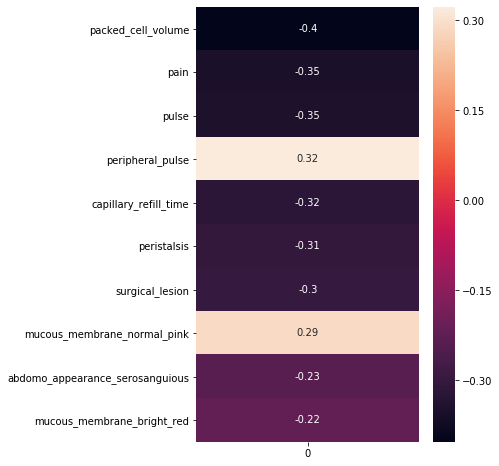

In [692]:
# Calcula a correlação entre todas as colunas e a coluna de resultado outcome
corr = df.corrwith(df["outcome"])

# Remove a coluna outcome para melhor visualização
corr.drop("outcome", inplace=True)

# Ordena os atributos pelo valor absoluto da correlação e 
# extrai apenas os 10 mais importantes
corr_df = pd.concat([corr, np.abs(corr)], axis=1)
corr_df.columns = ["Original values", "Absolute values"]
corr_df = corr_df.sort_values("Absolute values", ascending=False)
ten_best = corr_df.iloc[:10]
ten_best = ten_best["Original values"]

# Modifica o tamanho default da imagem para melhor visualização do heatmap
plt.figure(figsize = (5,8))

# Constrói um heatmap para visualização.
# A conversão do valores da coluna em numpy array é necessária para 
# visualização na vertical através da transposição 
ten_best_vals = np.array([ten_best.values]).T
sns.heatmap(ten_best_vals, yticklabels=ten_best.index, annot=True)

É interessante notar que o resultado da seleção através de correlação é idêntico aos valores obtidos com a função de rankeamento `f_classif` conforme pode ser verificado na célula abaixo.

Dessa forma, os valores obtidos com a correlação não serão incluídos na lista de atributos.

In [693]:
# Compara as listas de atributos relevantes gerada pela função f_classif
# com aqueles obtidos através da análise de correlação entre os atributos
# e a variável de saída

for a, b in zip(relevant_attrs["f_classif"],ten_best.index.values):
    print(a == b)


True
True
True
True
True
True
True
True
True
True


## 5. Balanceamento <a class="anchor" id="balanceamento"></a>

Conforme pode ser visto abaixo, existe um desbalanceio entre as classes 1 (cavalo sobreviveu) e 0 (morte ou eutanásia).

In [694]:
df["outcome"].value_counts()

1.0    178
0.0    121
Name: outcome, dtype: int64

Há diversas alternativas para a solução do problema de balanceamento como **undersampling** e **oversampling** que consistem, respectivamente, em reduzir e aumentar os conjuntos de opções através da remoção ou adição aleatória de elementos pré-existentes.

Esse relatório, porém, utilizará o método **SMOTE** (Synthetic Minority Oversampling TEchnique) que consiste em sintetizar elementos da classe minoritária com base nos elementos que já existem.

<img src="smote.png"/>

In [695]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X.values, y)
df_sm = pd.DataFrame(X_sm)
df_sm.columns = all_cols

Visualização dos dados pré e pós SMOTE considerando todos os atributos relevantes

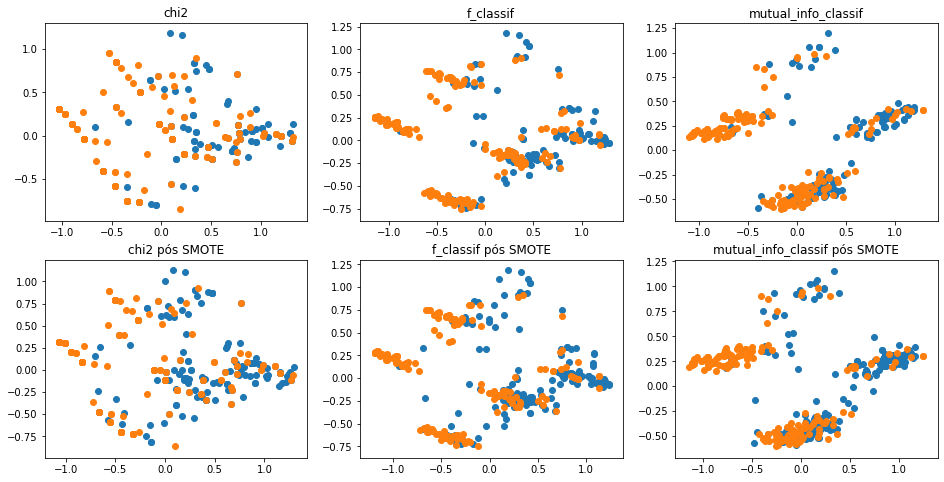

In [697]:
# Função para plotar os dados em um espaço bidimensional
pca = PCA(n_components=2)
plt.figure(figsize = (16,8))

for i,func in enumerate(relevant_attrs):
    plt.subplot(2, 3, i+1)
    X_2d = pca.fit_transform(X[relevant_attrs[func]])
    plt.scatter(X_2d[y==0,0], X_2d[y==0,1])
    plt.scatter(X_2d[y==1,0], X_2d[y==1,1])
    plt.title(func)
    
    plt.subplot(2, 3, i+4)
    X_2d = pca.fit_transform(df_sm[relevant_attrs[func]])
    plt.scatter(X_2d[y_sm==0,0], X_2d[y_sm==0,1])
    plt.scatter(X_2d[y_sm==1,0], X_2d[y_sm==1,1])
    plt.title(func + " pós SMOTE")
